In [ ]:
!pip install -q pyomo
!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
import os

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1S6X9VnRoharsjxi7ynW6GoTR1du-fG8o"})
downloaded.GetContentFile('Burden.xlsx')

downloaded = drive.CreateFile({'id':"1WUnwnSq0b-a31lmQYY4ecX8bs9oZG4s2"})
downloaded.GetContentFile('Demand.xlsx')

downloaded = drive.CreateFile({'id':"1JzhGuX3ZOZRvngZZiQ2_CKVTZcOSSMTs"})
downloaded.GetContentFile('Lambda.xlsx')

downloaded = drive.CreateFile({'id':"1ja_glXSEezSSjf_Fs3r_VPYgL2Ibw_TN"})
downloaded.GetContentFile('PV.xlsx')

downloaded = drive.CreateFile({'id':"181OwysQBfn8FtHYMp9aaO2N3-FR1fc5a"})
downloaded.GetContentFile('WT.xlsx')

Burden = pd.read_excel("Burden.xlsx")
PV = pd.read_excel("PV.xlsx")
WT = pd.read_excel("WT.xlsx")
Demand = pd.read_excel("Demand.xlsx")
Lambda = pd.read_excel("Lambda.xlsx")

In [ ]:
model = pyo.ConcreteModel()
########## Sets ############
model.T = pyo.RangeSet(1,24)
model.W = pyo.RangeSet(1,5)
########## Parameters ############
Pe_Purchased_max = 2000
Pe_Sold_max = 2000
Pe_storage_max = 200
Pe_charge_max = 200
Pe_discharge_max = 200
Lambda_charge = 0.1

PH2_Purchased_max = 600
PH2_Sold_max = 600
PH2_storage_max = 100
PH2_charge_max = 100
PH2_discharge_max = 100

Pg_Purchased_max = 2000
Ph_storage_max = 200
Ph_charge_max = 200
Ph_discharge_max = 200
#############################
P_CHP_max = 800
P_Boiler_max = 800
P_EL_max = 100
P_FC_max = 100

Eta_e_CHP = 0.4
Eta_h_CHP = 0.5
Eta_Boiler = 0.8
Eta_FC = 0.6
Eta_EL = 0.65
Eta_AC = 0.7

DR_e_max = 0.2
DR_h_max = 0.2
Lambda_DR_e = 0.1
Lambda_DR_h = 0.1
Lambda_O2 = 100 #Cent/Kgr

Gama_CHP = 0.3
Gama_Boiler = 0.3
Gama_E = 0.4
Gama_G = 0.45
########## Variables ############
model.Obj1 = pyo.Var()
model.Obj2 = pyo.Var()
model.Obj11 = pyo.Var()

model.Pe_Purchased = pyo.Var(model.T , within=pyo.PositiveReals)
model.Pe_Sold = pyo.Var(model.T , within=pyo.PositiveReals)
model.Pe_storage = pyo.Var(model.T , within=pyo.PositiveReals)
model.Pe_charge = pyo.Var(model.T , within=pyo.PositiveReals)
model.Pe_discharge = pyo.Var(model.T , within=pyo.PositiveReals)

model.PH2_Purchased = pyo.Var(model.T , within=pyo.PositiveReals)
model.PH2_Sold = pyo.Var(model.T , within=pyo.PositiveReals)
model.PH2_storage = pyo.Var(model.T , within=pyo.PositiveReals)
model.PH2_charge = pyo.Var(model.T , within=pyo.PositiveReals)
model.PH2_discharge = pyo.Var(model.T , within=pyo.PositiveReals)

model.Pg_Purchased = pyo.Var(model.T , within=pyo.PositiveReals)

model.P_CHP = pyo.Var(model.T , within=pyo.PositiveReals)
model.P_Boiler = pyo.Var(model.T , within=pyo.PositiveReals)
model.P_EL = pyo.Var(model.T , within=pyo.PositiveReals)
model.P_FC= pyo.Var(model.T , within=pyo.PositiveReals)
model.P_AC = pyo.Var(model.T , within=pyo.PositiveReals)

model.Pe_afterDRP = pyo.Var(model.T , within=pyo.PositiveReals)
model.Le_increase = pyo.Var(model.T , within=pyo.PositiveReals)
model.DR_e = pyo.Var(model.T , within=pyo.PositiveReals)
model.Ph_afterDRP = pyo.Var(model.T , within=pyo.PositiveReals)
model.Lh_increase = pyo.Var(model.T , within=pyo.PositiveReals)
model.DR_h = pyo.Var(model.T , within=pyo.PositiveReals)

model.O_2_Sold = pyo.Var(model.T , within=pyo.PositiveReals)
# Fixing the start and the end value of storages
model.Pe_storage[1].fix(Pe_storage_max)
model.Pe_storage[24].fix(Pe_storage_max)
model.PH2_storage[1].fix(PH2_storage_max)
model.PH2_storage[24].fix(PH2_storage_max)
########## Binary Variables ############
model.Ie_Purchased = pyo.Var(model.T , within=pyo.Binary)
model.Ie_Sold = pyo.Var(model.T , within=pyo.Binary)
model.Ie_charge = pyo.Var(model.T , within=pyo.Binary)
model.Ie_discharge = pyo.Var(model.T , within=pyo.Binary)
model.IH2_Purchased = pyo.Var(model.T , within=pyo.Binary)
model.IH2_Sold = pyo.Var(model.T , within=pyo.Binary)
model.IH2_charge = pyo.Var(model.T , within=pyo.Binary)
model.IH2_discharge = pyo.Var(model.T , within=pyo.Binary)
model.I_EL = pyo.Var(model.T , within=pyo.Binary)
model.I_FC = pyo.Var(model.T , within=pyo.Binary)
########## Constraints ############
# Transaction with electrical grid
def CR2(model,t):
  return model.Pe_Purchased[t] <= Pe_Purchased_max*model.Ie_Purchased[t]
model.Con2 = pyo.Constraint(model.T , rule=CR2)

def CR3(model,t):
  return model.Pe_Sold[t] <= Pe_Sold_max*model.Ie_Sold[t]
model.Con3 = pyo.Constraint(model.T , rule=CR3)

def CR4(model,t):
  return model.Ie_Purchased[t] + model.Ie_Sold[t] <= 1
model.Con4 = pyo.Constraint(model.T , rule=CR4)

# Transaction with hydrogen grid
def CR22(model,t):
  return model.PH2_Purchased[t] <= PH2_Purchased_max*model.IH2_Purchased[t]
model.Con22 = pyo.Constraint(model.T , rule=CR22)

def CR23(model,t):
  return model.PH2_Sold[t] <= PH2_Sold_max*model.IH2_Sold[t]
model.Con23 = pyo.Constraint(model.T , rule=CR23)

def CR24(model,t):
  return model.IH2_Purchased[t] + model.IH2_Sold[t] <= 1
model.Con24 = pyo.Constraint(model.T , rule=CR24)

# Gas network
def CR40(model,t):
  return model.Pg_Purchased[t] <= Pg_Purchased_max
model.Con40 = pyo.Constraint(model.T , rule=CR40)

# Electrical storage
def CR5(model,t):
  return model.Pe_charge[t] <= Pe_charge_max*model.Ie_charge[t]
model.Con5 = pyo.Constraint(model.T , rule=CR5)

def CR6(model,t):
  return model.Pe_discharge[t] <= Pe_discharge_max*model.Ie_discharge[t]
model.Con6 = pyo.Constraint(model.T , rule=CR6)

def CR7(model,t):
  return model.Ie_charge[t] + model.Ie_discharge[t] <= 1
model.Con7 = pyo.Constraint(model.T , rule=CR7)

def CR9(model,t):
  return model.Pe_storage[t] <= Pe_storage_max
model.Con9 = pyo.Constraint(model.T , rule=CR9)

def CR8(model,t):
  if t > 1:
    return model.Pe_storage[t] == model.Pe_storage[t-1] + model.Pe_charge[t] - model.Pe_discharge[t]
  else:
    return model.Pe_storage[t] == model.Pe_storage[t] + model.Pe_charge[t] - model.Pe_discharge[t]
model.Con8 = pyo.Constraint(model.T , rule=CR8)

# Hydrogen storage
def CR15(model,t):
  return model.PH2_charge[t] <= PH2_charge_max*model.IH2_charge[t]
model.Con15 = pyo.Constraint(model.T , rule=CR15)

def CR16(model,t):
  return model.PH2_discharge[t] <= PH2_discharge_max*model.IH2_discharge[t]
model.Con16 = pyo.Constraint(model.T , rule=CR16)

def CR17(model,t):
  return model.IH2_charge[t] + model.IH2_discharge[t] <= 1
model.Con17 = pyo.Constraint(model.T , rule=CR17)

def CR19(model,t):
  return model.PH2_storage[t] <= PH2_storage_max
model.Con19 = pyo.Constraint(model.T , rule=CR19)

def CR20(model,t):
  if t > 1:
    return model.PH2_storage[t] == model.PH2_storage[t-1] + model.PH2_charge[t] - model.PH2_discharge[t]
  else:
    return model.PH2_storage[t] == model.PH2_storage[t] + model.PH2_charge[t] - model.PH2_discharge[t]
model.Con20 = pyo.Constraint(model.T , rule=CR20);

# Electrolyzer and fuelcell
def CR10(model,t):
  return model.P_EL[t] <= P_EL_max*model.I_EL[t]
model.Con10 = pyo.Constraint(model.T , rule=CR10)

def CR11(model,t):
  return model.P_FC[t] <= P_FC_max*model.I_FC[t]
model.Con11 = pyo.Constraint(model.T , rule=CR11)

def CR12(model,t):
  return model.I_FC[t] + model.I_EL[t] <= 1
model.Con12 = pyo.Constraint(model.T , rule=CR12)

# CHP and boiler
def CR13(model,t):
  return model.P_CHP[t] <= P_CHP_max
model.Con13 = pyo.Constraint(model.T , rule=CR13)

def CR37(model,t):
  return model.P_Boiler[t] <= P_Boiler_max
model.Con37 = pyo.Constraint(model.T , rule=CR37)

# Electrical power equality
def CR1(model,t):
  return model.Pe_Purchased[t] + model.Pe_discharge[t] + sum(0.2*WT.loc[t-1].at[w] for w in model.W) + sum(0.2*PV.loc[t-1].at[w] for w in model.W) + Eta_FC*model.P_FC[t] + Eta_e_CHP*model.P_CHP[t] == model.Pe_Sold[t] + model.Pe_afterDRP[t] + model.Pe_charge[t] + model.P_EL[t]
model.Con1 = pyo.Constraint(model.T , rule=CR1)

# Hydrogen power equality
def CR14(model,t):
  return model.PH2_Purchased[t] + Eta_EL*model.P_EL[t] + model.PH2_discharge[t] == model.PH2_Sold[t] + Demand.loc[t-1].at["DH2"] + model.P_FC[t] + model.PH2_charge[t]
model.Con14 = pyo.Constraint(model.T , rule=CR14)

# Natural gas power equality
def CR21(model,t):
  return model.Pg_Purchased[t] == model.P_CHP[t] + model.P_Boiler[t]
model.Con21 = pyo.Constraint(model.T , rule=CR21)

# Heat power equality
def CR25(model,t):
  return Eta_h_CHP*model.P_CHP[t] + Eta_Boiler*model.P_Boiler[t] == model.Ph_afterDRP[t]  + model.P_AC[t]
model.Con25 = pyo.Constraint(model.T , rule=CR25)

# Cool power equality
def CR26(model,t):
  return Eta_AC*model.P_AC[t] == Demand.loc[t-1].at["Dc"]
model.Con26 = pyo.Constraint(model.T , rule=CR26)

# Electrical demand response
def CR31(model,t):
  return model.Pe_afterDRP[t] == Demand.loc[t-1].at["De"] + model.Le_increase[t] - Demand.loc[t-1].at["De"]*model.DR_e[t]
model.Con31 = pyo.Constraint(model.T , rule=CR31)

def CR32(model,t):
  return model.DR_e[t] <= DR_e_max
model.Con32 = pyo.Constraint(model.T , rule=CR32)

def CR33(model):
  return sum(model.Le_increase[t] for t in model.T) == sum(Demand.loc[t-1].at["De"]*model.DR_e[t] for t in model.T)
model.Con33 = pyo.Constraint(rule=CR33)

# Heat demand response
def CR34(model,t):
  return model.Ph_afterDRP[t] == Demand.loc[t-1].at["Dh"] + model.Lh_increase[t] - Demand.loc[t-1].at["Dh"]*model.DR_h[t]
model.Con34 = pyo.Constraint(model.T , rule=CR34)

def CR35(model,t):
  return model.DR_h[t] <= DR_h_max
model.Con35 = pyo.Constraint(model.T , rule=CR35)

def CR36(model):
  return sum(model.Lh_increase[t] for t in model.T) == sum(Demand.loc[t-1].at["Dh"]*model.DR_h[t] for t in model.T)
model.Con36 = pyo.Constraint(rule=CR36)

# Oxygen production
def CR38(model,t):
  return model.O_2_Sold[t] == 8*Eta_EL*model.P_EL[t]/38.44
model.Con38 = pyo.Constraint(model.T , rule=CR38)
########## Objective Function ############
Obj11 = sum((model.Pe_Purchased[t] - model.Pe_Sold[t])* Lambda.loc[t-1].at["Lam_e"] for t in model.T)
Obj12 = sum((model.Pe_charge[t] + model.Pe_discharge[t])*Lambda_charge for t in model.T)
Obj13 = sum((model.PH2_Purchased[t] - model.PH2_Sold[t])*Lambda.loc[t-1].at["Lam_H2"] for t in model.T)
Obj14 = sum((model.PH2_charge[t] + model.PH2_discharge[t])*Lambda_charge for t in model.T)
Obj15 = sum(model.Pg_Purchased[t] * Lambda.loc[t-1].at["Lam_g"] for t in model.T)
Obj17 = sum(model.Le_increase[t]*Burden.loc[t-1].at["Burden_e"]*Lambda_DR_e for t in model.T)
Obj18 = sum(model.Lh_increase[t]*Burden.loc[t-1].at["Burden_h"]*Lambda_DR_h for t in model.T)
Obj19 = sum(model.O_2_Sold[t]*2*Lambda_O2 for t in model.T)

Obj21 = sum(Gama_CHP*model.P_CHP[t] for t in model.T)
Obj22 = sum(Gama_Boiler*model.P_Boiler[t] for t in model.T)
Obj23 = sum(Gama_E*model.Pe_Purchased[t] for t in model.T)
Obj24 = sum(Gama_G*model.Pg_Purchased[t] for t in model.T)

def CR39(model,t):
  return model.Obj1 == Obj11 + Obj12 + Obj13 + Obj14 + Obj15 + Obj17 + Obj18 - Obj19
model.Con39 = pyo.Constraint(model.T , rule=CR39)

def CR40(model,t):
  return model.Obj2 == Obj21 + Obj22 + Obj23 + Obj24
model.Con40 = pyo.Constraint(model.T , rule=CR40)

OF1min = 272234.61286899523
OF2min = 26939.55642036973
OF = 0.5*model.Obj1/272234.61286899523 + 0.5*model.Obj2/26939.55642036973

model.OF = pyo.Objective(expr=OF , sense=pyo.minimize)
# model.OF1 = pyo.Objective(expr = model.Obj1 , sense=pyo.minimize)
# model.OF2 = pyo.Objective(expr = model.Obj2 , sense=pyo.minimize)

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


In [ ]:
# model.OF1.deactivate()
# model.OF2.activate()

os.environ["NEOS_EMAIL"] = " 123@gmail.com"
solver_manager = pyo.SolverManagerFactory("neos")

result = solver_manager.solve(model , opt="cplex").write()
# print( 'OF1 = ' + str(pyo.value(model.OF1)) )
# print( 'OF2 = ' + str(pyo.value(model.OF2)) )

# 100 Cent
# OF1 = 272234.61286899523
# OF2 = 28623.10194138547

# OF1 = 357411.95852035965
# OF2 = 26939.55642036973

# 200 Cent
# OF1 = 207302.2507462063
# OF2 = 28623.10194138547

# OF1 = 357411.95852035965
# OF2 = 26939.55642036973

# 50 Cent
# OF1 = 302531.824107288
# OF2 = 28480.302819379514

# OF1 = 357411.95852035965
# OF2 = 26939.55642036973


# 150277.9884317
# 173834.4681612503

# 1.0253788198598657
# 1.0977417457492893

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 790
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: CPLEX 22.1.2\x3a optimal solution; objective 1.0254890189256; 156 simplex iterations
  Termination condition: optimal
  Id: 0
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [ ]:
import openpyxl as op
book = op.Workbook()
book.create_sheet('Simulation Results')
sheet = book.get_sheet_by_name('Simulation Results')

Pe_Purchased = []
Pe_Sold = []
Pe_storage = []
Pe_charge = []
Pe_discharge = []
PH2_Purchased = []
PH2_Sold = []
PH2_storage = []
PH2_charge = []
PH2_discharge = []
Pg_Purchased = []
P_CHP = []
P_Boiler = []
P_EL = []
P_FC = []
P_AC = []
Pe_afterDRP = []
Le_increase = []
DR_e = []
Ph_afterDRP = []
Lh_increase = []
DR_h = []
O_2_Sold = []

for i in model.T:
  Pe_Purchased.append(model.Pe_Purchased[i].value)
  sheet.cell(row=1 , column=1).value = "Pe_Purchased"
  sheet.cell(row=i+1 , column=1).value = Pe_Purchased[i-1]

for i in model.T:
  Pe_Sold.append(model.Pe_Sold[i].value)
  sheet.cell(row=1 , column=2).value = "Pe_Sold"
  sheet.cell(row=i+1 , column=2).value = Pe_Sold[i-1]

for i in model.T:
  Pe_charge.append(model.Pe_charge[i].value)
  sheet.cell(row=1 , column=3).value = "Pe_charge"
  sheet.cell(row=i+1 , column=3).value = Pe_charge[i-1]

for i in model.T:
  Pe_storage.append(model.Pe_storage[i].value)
  sheet.cell(row=1 , column=4).value = "Pe_storage"
  sheet.cell(row=i+1 , column=4).value = Pe_storage[i-1]

for i in model.T:
  Pe_discharge.append(model.Pe_discharge[i].value)
  sheet.cell(row=1 , column=5).value = "Pe_discharge"
  sheet.cell(row=i+1 , column=5).value = Pe_discharge[i-1]

for i in model.T:
  PH2_Purchased.append(model.PH2_Purchased[i].value)
  sheet.cell(row=1 , column=6).value = "PH2_Purchased"
  sheet.cell(row=i+1 , column=6).value = PH2_Purchased[i-1]

for i in model.T:
  PH2_Sold.append(model.PH2_Sold[i].value)
  sheet.cell(row=1 , column=7).value = "PH2_Sold"
  sheet.cell(row=i+1 , column=7).value = PH2_Sold[i-1]

for i in model.T:
  PH2_storage.append(model.PH2_storage[i].value)
  sheet.cell(row=1 , column=8).value = "PH2_storage"
  sheet.cell(row=i+1 , column=8).value = PH2_storage[i-1]

for i in model.T:
  PH2_charge.append(model.PH2_charge[i].value)
  sheet.cell(row=1 , column=9).value = "PH2_charge"
  sheet.cell(row=i+1 , column=9).value = PH2_charge[i-1]

for i in model.T:
  PH2_discharge.append(model.PH2_discharge[i].value)
  sheet.cell(row=1 , column=10).value = "PH2_discharge"
  sheet.cell(row=i+1 , column=10).value = PH2_discharge[i-1]

for i in model.T:
  Pg_Purchased.append(model.Pg_Purchased[i].value)
  sheet.cell(row=1 , column=11).value = "Pg_Purchased"
  sheet.cell(row=i+1 , column=11).value = Pg_Purchased[i-1]

for i in model.T:
  P_CHP.append(model.P_CHP[i].value)
  sheet.cell(row=1 , column=15).value = "P_CHP"
  sheet.cell(row=i+1 , column=15).value = P_CHP[i-1]

for i in model.T:
  P_Boiler.append(model.P_Boiler[i].value)
  sheet.cell(row=1 , column=16).value = "P_Boiler"
  sheet.cell(row=i+1 , column=16).value = P_Boiler[i-1]

for i in model.T:
  P_EL.append(model.P_EL[i].value)
  sheet.cell(row=1 , column=17).value = "P_EL"
  sheet.cell(row=i+1 , column=17).value = P_EL[i-1]

for i in model.T:
  P_FC.append(model.P_FC[i].value)
  sheet.cell(row=1 , column=18).value = "P_FC"
  sheet.cell(row=i+1 , column=18).value = P_FC[i-1]

for i in model.T:
  P_AC.append(model.P_AC[i].value)
  sheet.cell(row=1 , column=19).value = "P_AC"
  sheet.cell(row=i+1 , column=19).value = P_AC[i-1]

for i in model.T:
  Pe_afterDRP.append(model.Pe_afterDRP[i].value)
  sheet.cell(row=1 , column=20).value = "Pe_afterDRP"
  sheet.cell(row=i+1 , column=20).value = Pe_afterDRP[i-1]

for i in model.T:
  Le_increase.append(model.Le_increase[i].value)
  sheet.cell(row=1 , column=21).value = "Le_increase"
  sheet.cell(row=i+1 , column=21).value = Le_increase[i-1]

for i in model.T:
  DR_e.append(model.DR_e[i].value)
  sheet.cell(row=1 , column=22).value = "DR_e"
  sheet.cell(row=i+1 , column=22).value = DR_e[i-1]

for i in model.T:
  Ph_afterDRP.append(model.Ph_afterDRP[i].value)
  sheet.cell(row=1 , column=23).value = "Ph_afterDRP"
  sheet.cell(row=i+1 , column=23).value = Ph_afterDRP[i-1]

for i in model.T:
  Lh_increase.append(model.Lh_increase[i].value)
  sheet.cell(row=1 , column=24).value = "Lh_increase"
  sheet.cell(row=i+1 , column=24).value = Lh_increase[i-1]

for i in model.T:
  DR_h.append(model.DR_h[i].value)
  sheet.cell(row=1 , column=25).value = "DR_h"
  sheet.cell(row=i+1 , column=25).value = DR_h[i-1]

for i in model.T:
  O_2_Sold.append(model.O_2_Sold[i].value)
  sheet.cell(row=1 , column=26).value = "O_2_Sold"
  sheet.cell(row=i+1 , column=26).value = O_2_Sold[i-1]

book.save('Outputs.xlsx')

<ipython-input-5-73dccc5d9be1>:4: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  sheet = book.get_sheet_by_name('Simulation Results')


In [ ]:
# Deactive OF2 and minimize OF1
model.OF2.deactivate()

os.environ["NEOS_EMAIL"] = " 123@gmail.com"
solver_manager = pyo.SolverManagerFactory("neos")

result = solver_manager.solve(model , opt="cplex").write()

print( 'OF1 = ' + str(pyo.value(model.OF1)) )
print( 'OF2 = ' + str(pyo.value(model.OF2)) )

OF1_min = pyo.value(model.OF1)
OF2_max = pyo.value(model.OF2)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 794
  Number of variables: 790
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: CPLEX 20.1.0.0\x3a optimal integer solution within mipgap or absmipgap; objective 302531.8241072885; 122 MIP simplex iterations; 0 branch-and-bound nodes; absmipgap = 15.2507, relmipgap = 5.04104e-05
  Termination condition: optimal
  Id: 3
# ----------------------------------------------------------
#   Solution Information
# ----------------

In [ ]:
# Deactive OF1 and fix OF1 on OF1-min, then minimize OF2
model.OF1.deactivate()
model.Obj1.fix(OF1_min)
model.OF2.activate()

os.environ["NEOS_EMAIL"] = "123@gmail.com"
solver_manager = pyo.SolverManagerFactory("neos")

result = solver_manager.solve(model , opt="cplex").write()

print( 'OF1 = ' + str(pyo.value(model.OF1)) )
print( 'OF2 = ' + str(pyo.value(model.OF2)) )

OF1_min = pyo.value(model.OF1)
OF2_max = pyo.value(model.OF2)
# model.pprint()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 794
  Number of variables: 789
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: CPLEX 20.1.0.0\x3a optimal integer solution; objective 28142.74983508104; 300 MIP simplex iterations; 0 branch-and-bound nodes; absmipgap = 3.63798e-12, relmipgap = 1.29269e-16
  Termination condition: optimal
  Id: 2
# ----------------------------------------------------------
#   Solution Information
# ---------------------------------------

In [ ]:
# Deactive OF1 and minimize OF2
model.Obj1.unfix()
model.OF2.activate()
model.OF1.deactivate()

result = solver_manager.solve(model , opt="cplex").write()

print( 'OF1 = ' + str(pyo.value(model.OF1)) )
print( 'OF2 = ' + str(pyo.value(model.OF2)) )

OF1_max = pyo.value(model.OF1)
OF2_min = pyo.value(model.OF2)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 794
  Number of variables: 790
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: CPLEX 20.1.0.0\x3a optimal integer solution; objective 26939.556420369725; 46 MIP simplex iterations; 0 branch-and-bound nodes; absmipgap = 3.63798e-12, relmipgap = 1.35042e-16
  Termination condition: optimal
  Id: 2
# ----------------------------------------------------------
#   Solution Information
# ---------------------------------------

In [ ]:
# Normal e_Constraint
model.OF1.activate()
model.OF2.deactivate()

model.e = pyo.Param(initialize=0, mutable=True)

model.C_epsilon = pyo.Constraint(expr = model.OF2 <= model.e)

n = 8
step = int((OF2_max - OF2_min) / n-4)
steps = [OF2_min] + list(range(int(OF2_min+step),int(OF2_max-step),step)) + [OF2_max]

x = []
y = []

for i in steps:
    model.e = i
    result = solver_manager.solve(model , opt="cplex")
    x.append(pyo.value(model.OF1))
    y.append(pyo.value(model.OF2))
    print(i)

26939.55642036973
27085
27231
27377
27523
27669
27815
27961
28142.74983508099


In [ ]:
print(x)
print(y)

[295597.59857834206, 289485.69591656164, 284021.1560039992, 280256.9011735041, 278439.10598594934, 276867.5661143531, 275318.0067818587, 273793.10678185866, 272051.3434965763]
[26939.556420369736, 27095.0, 27251.0, 27407.0, 27563.0, 27719.0, 27875.0, 28031.0, 28222.894187686572]


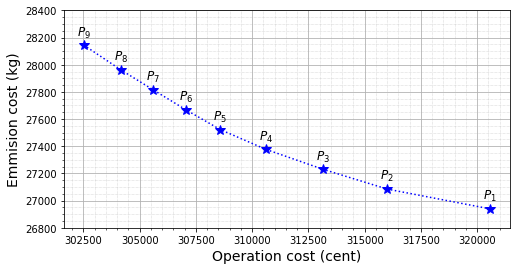

In [ ]:
plt.figure(figsize=(8 , 4))
plt.minorticks_on()

ytick = range(26800 , 28600 , 200)
# x = range(270000 , 330000 , 100000)

plt.plot(x , y , color='blue' , marker='*' , linestyle='dotted' , ms=10);

plt.grid()
plt.grid(which='minor', axis = "both" , linestyle='dotted', linewidth='0.5')

plt.annotate('$P_1$' , xy=(x[0],y[0]) , xytext=(x[0],y[0]+70) ,
             horizontalalignment='center' , fontsize=12)
plt.annotate('$P_2$' , xy=(x[1],y[1]) , xytext=(x[1],y[1]+70) ,
             horizontalalignment='center' , fontsize=12)
plt.annotate('$P_3$' , xy=(x[2],y[2]) , xytext=(x[2],y[2]+70) ,
             horizontalalignment='center' , fontsize=12)
plt.annotate('$P_4$' , xy=(x[3],y[3]) , xytext=(x[3],y[3]+70) ,
             horizontalalignment='center' , fontsize=12)
plt.annotate('$P_5$' , xy=(x[4],y[4]) , xytext=(x[4],y[4]+70) ,
             horizontalalignment='center' , fontsize=12)
plt.annotate('$P_6$' , xy=(x[5],y[5]) , xytext=(x[5],y[5]+70) ,
             horizontalalignment='center' , fontsize=12)
plt.annotate('$P_7$' , xy=(x[6],y[6]) , xytext=(x[6],y[6]+70) ,
             horizontalalignment='center' , fontsize=12)
plt.annotate('$P_8$' , xy=(x[7],y[7]) , xytext=(x[7],y[7]+70) ,
             horizontalalignment='center' , fontsize=12)
plt.annotate('$P_9$' , xy=(x[8],y[8]) , xytext=(x[8],y[8]+70) ,
             horizontalalignment='center' , fontsize=12)

font1 = {"size":14}

plt.xlabel("Operation cost (cent)" , fontdict=font1)
plt.ylabel("Emmision cost (kg)" , fontdict=font1)

plt.yticks(ytick)

plt.savefig("Ch5Fig5.pdf", format="pdf", bbox_inches="tight")
# plt.grid(True);

In [ ]:
# Qualification of all Parreto solutions in Operation cost
import numpy as np
from numpy.linalg import eig
import termcolor
row = 9
column = 9

a = [1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 ,
     1/2 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 7 ,
     1/3 , 2/3 , 1 , 2 , 3 , 4 , 5 , 6 , 7 ,
     1/4 , 2/4 , 3/4 , 1 , 2 , 3 , 4 , 5 , 6 ,
     1/5 , 2/5 , 3/5 , 4/5 , 1 , 2 , 3 , 4 , 5 ,
     1/6 , 2/6 , 3/6 , 4/6 , 5/6 , 1 , 2 , 3 , 4 ,
     1/7 , 2/7 , 3/7 , 4/7 , 5/7 , 6/7 , 1 , 2 , 3 ,
     1/8 , 2/8 , 3/8 , 4/8 , 5/8 , 6/8 , 7/8 , 1 , 2 ,
     1/9 , 2/9 , 3/9 , 4/9 , 5/9 , 6/9 , 7/9 , 8/9 , 1 ]

m1 = np.array(a)
m1 = m1.reshape(row , column)
values , vectors = eig(m1)
print("Eigenvalue", termcolor.colored(f" \n {values}", "red"))
print("Eigenvector", termcolor.colored(f" \n {vectors}", "blue"))

total = 0

for i in range(row):
    total += vectors[i,0]

normalized = np.zeros([1,row])

for j in range(row):
    normalized[0,j] = float(vectors[j,0])/total
print("Normalized eigenvector", termcolor.colored(f" \n {normalized}", "yellow"))

In [ ]:
import numpy as np
from numpy.linalg import eig
import termcolor
row = 9
column = 9

a = [1 , 1/2 , 1/3 , 1/4 , 1/5 , 1/6 , 1/7 , 1/8 , 1/9 ,
     2 , 1 , 2/3 , 2/4 , 2/5 , 2/6 , 2/7 , 2/8 , 2/9 ,
     3 , 2 , 1 , 3/4 , 3/5 , 3/6 , 3/7 , 3/8 , 3/9 ,
     4 , 3 , 2 , 1 , 4/5 , 4/6 , 4/7 , 4/8 , 4/9 ,
     5 , 4 , 3 , 2 , 1 , 5/6 , 5/7 , 5/8 , 5/9 ,
     6 , 5 , 4 , 3 , 2 , 1 , 6/7 , 6/8 , 6/9 ,
     7 , 6 , 5 , 4 , 3 , 2 , 1 , 7/8 , 7/9 ,
     8 , 7 , 6 , 5 , 4 , 3 , 2 , 1 , 8/9 ,
     9 , 8 , 7 , 6 , 5 , 4 , 3 , 2 , 1 ]

m1 = np.array(a)
m1 = m1.reshape(row , column)
values , vectors = eig(m1)
print("Eigenvalue", termcolor.colored(f" \n {values}", "red"))
print("Eigenvector", termcolor.colored(f" \n {vectors}", "blue"))

total = 0

for i in range(row):
    total += vectors[i,0]

normalized = np.zeros([1,row])

for j in range(row):
    normalized[0,j] = float(vectors[j,0])/total
print("Normalized eigenvector", termcolor.colored(f" \n {normalized}", "yellow"))


Eigenvalue  
 [ 1.17437810e+01+0.j         -7.02141188e-01+1.05429295j
 -7.02141188e-01-1.05429295j -3.31472066e-16+0.j
 -3.55265571e-01+0.1753094j  -3.55265571e-01-0.1753094j
 -2.23182994e-01+0.04033851j -2.23182994e-01-0.04033851j
 -1.82601488e-01+0.j        ]
Eigenvector  
 [[ 3.68344323e-02+0.j         -6.18947651e-03-0.03333088j
  -6.18947651e-03+0.03333088j  1.10431526e-01+0.j
   2.31316577e-02+0.0231974j   2.31316577e-02-0.0231974j
  -3.05728114e-02-0.00983493j -3.05728114e-02+0.00983493j
   3.98835140e-02+0.j        ]
 [ 7.36688646e-02+0.j         -1.23789530e-02-0.06666176j
  -1.23789530e-02+0.06666176j  1.37287634e-16+0.j
   4.62633155e-02+0.04639481j  4.62633155e-02-0.04639481j
  -6.11456229e-02-0.01966987j -6.11456229e-02+0.01966987j
   7.97670280e-02+0.j        ]
 [ 1.13639802e-01+0.j         -3.77606636e-02-0.08134021j
  -3.77606636e-02+0.08134021j -1.24806940e-16+0.j
   4.29455462e-02-0.00875548j  4.29455462e-02+0.00875548j
   3.32208017e-02+0.03714363j  3.32208017e-02-0

<ipython-input-4-98b3edd34ea0>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  normalized[0,j] = float(vectors[j,0])/total


In [ ]:
# Qualification of all Parreto solutions in Operation cost
import numpy as np
from numpy.linalg import eig
import termcolor
row = 9
column = 9

a = [1 , x[0]/x[1] , x[0]/x[2] , x[0]/x[3] , x[0]/x[4] , x[0]/x[5] , x[0]/x[6] , x[0]/x[7] , x[0]/x[8] ,
     x[1]/x[0] , 1 , x[1]/x[2] , x[1]/x[3] , x[1]/x[4] , x[1]/x[5] , x[1]/x[6] , x[1]/x[7] , x[1]/x[8] ,
     x[2]/x[0] , x[2]/x[1] , 1 , x[2]/x[3] , x[2]/x[4] , x[2]/x[5] , x[2]/x[6] , x[2]/x[7] , x[2]/x[8] ,
     x[3]/x[0] , x[3]/x[1] , x[3]/x[2] , 1 , x[3]/x[4] , x[3]/x[5] , x[3]/x[6] , x[3]/x[7] , x[3]/x[8] ,
     x[4]/x[0] , x[4]/x[1] , x[4]/x[2] , x[4]/x[3] , 1 , x[4]/x[5] , x[4]/x[6] , x[4]/x[7] , x[4]/x[8] ,
     x[5]/x[0] , x[5]/x[1] , x[5]/x[2] , x[5]/x[3] , x[5]/x[4] , 1 , x[5]/x[6] , x[5]/x[7] , x[5]/x[8] ,
     x[6]/x[0] , x[6]/x[1] , x[6]/x[2] , x[6]/x[3] , x[6]/x[4] , x[6]/x[5] , 1 , x[6]/x[7] , x[6]/x[8] ,
     x[7]/x[0] , x[7]/x[1] , x[7]/x[2] , x[7]/x[3] , x[7]/x[4] , x[7]/x[5] , x[7]/x[6] , 1 , x[7]/x[8] ,
     x[8]/x[0] , x[8]/x[1] , x[8]/x[2] , x[8]/x[3] , x[8]/x[4] , x[8]/x[5] , x[8]/x[6] , x[8]/x[7] , 1 ]

m1 = np.array(a)
m1 = m1.reshape(row , column)
values , vectors = eig(m1)
print("Eigenvalue", termcolor.colored(f" \n {values}", "red"))
print("Eigenvector", termcolor.colored(f" \n {vectors}", "blue"))

total = 0

for i in range(row):
    total += vectors[i,1]

normalized = np.zeros([1,row])

for j in range(row):
    normalized[0,j] = float(vectors[j,1])/total
print("Normalized eigenvector", termcolor.colored(f" \n {normalized}", "yellow"))

book.create_sheet('Analytic Hierarchy Process')
sheet2 = book.get_sheet_by_name('Analytic Hierarchy Process')

sheet2.cell(row=2 , column=1).value = "Q11"
sheet2.cell(row=3 , column=1).value = "Q12"
sheet2.cell(row=4 , column=1).value = "Q13"
sheet2.cell(row=5 , column=1).value = "Q14"
sheet2.cell(row=6 , column=1).value = "Q15"
sheet2.cell(row=7 , column=1).value = "Q16"
sheet2.cell(row=8 , column=1).value = "Q17"
sheet2.cell(row=9 , column=1).value = "Q18"
sheet2.cell(row=10 , column=1).value = "Q19"

sheet2.cell(row=1 , column=2).value = "First Objective"
for i in range(0 , row):
    sheet2.cell(row=i+2 , column=2).value = normalized[0 , i]

book.save('Multi Objective Output.xlsx')
print(m1)

In [ ]:
# Qualification of all Parreto solutions in emission cost
row = 9
column = 9

b = [1 , y[0]/y[1] , y[0]/y[2] , y[0]/y[3] , y[0]/y[4] , y[0]/y[5] , y[0]/y[6] , y[0]/y[7] , y[0]/y[8] ,
     y[1]/y[0] , 1 , y[1]/y[2] , y[1]/y[3] , y[1]/y[4] , y[1]/y[5] , y[1]/y[6] , y[1]/y[7] , y[1]/y[8] ,
     y[2]/y[0] , y[2]/y[1] , 1 , y[2]/y[3] , y[2]/y[4] , y[2]/y[5] , y[2]/y[6] , y[2]/y[7] , y[2]/y[8] ,
     y[3]/y[0] , y[3]/y[1] , y[3]/y[2] , 1 , y[3]/y[4] , y[3]/y[5] , y[3]/y[6] , y[3]/y[7] , y[3]/y[8] ,
     y[4]/y[0] , y[4]/y[1] , y[4]/y[2] , y[4]/y[3] , 1 , y[4]/y[5] , y[4]/y[6] , y[4]/y[7] , y[4]/y[8] ,
     y[5]/y[0] , y[5]/y[1] , y[5]/y[2] , y[5]/y[3] , y[5]/y[4] , 1 , y[5]/y[6] , y[5]/y[7] , y[5]/y[8] ,
     y[6]/y[0] , y[6]/y[1] , y[6]/y[2] , y[6]/y[3] , y[6]/y[4] , y[6]/y[5] , 1 , y[6]/y[7] , y[6]/y[8] ,
     y[7]/y[0] , y[7]/y[1] , y[7]/y[2] , y[7]/y[3] , y[7]/y[4] , y[7]/y[5] , y[7]/y[6] , 1 , y[7]/y[8] ,
     y[8]/y[0] , y[8]/y[1] , y[8]/y[2] , y[8]/y[3] , y[8]/y[4] , y[8]/y[5] , y[8]/y[6] , y[8]/y[7] , 1 ]
m2 = np.array(b)
m2 = m2.reshape(row , column)
values , vectors = eig(m2)

values , vectors = eig(m2)
print("Eigenvalue", termcolor.colored(f" \n {values}", "red"))
print("Eigenvector", termcolor.colored(f" \n {vectors}", "blue"))
total = 0

for i in range(row):
    total += vectors[i,1]

normalized = np.zeros([1,row])

for j in range(row):
    normalized[0,j] = float(vectors[j,1])/total
print("Normalized eigenvector", termcolor.colored(f" \n {normalized}", "yellow"))

# sheet = book.get_sheet_by_name('Analytic Hierarchy Process')
sheet2.cell(row=1 , column=3).value = "Second Objective"
for i in range(0 , row):
    sheet2.cell(row=i+2 , column=3).value = normalized[0 , i]

book.save('Multi Objective Output.xlsx')
print(m2)

In [ ]:
# Qualification of all Parreto solutions in Operation cost
import numpy as np
from numpy.linalg import eig
import termcolor
row = 2
column = 2

a = [1 , 6,
     1/6 , 1]

m = np.array(a)
m = m.reshape(row , column)
values , vectors = eig(m)
print("Eigenvalue", termcolor.colored(f" \n {values}", "red"))
print("Eigenvector", termcolor.colored(f" \n {vectors}", "blue"))

total = 0

for i in range(row):
    total += vectors[i,0]

normalized = np.zeros([1,row])

for j in range(row):
    normalized[0,j] = float(vectors[j,0])/total
print("Normalized eigenvector", termcolor.colored(f" \n {normalized}", "yellow"))

book.create_sheet('Analytic Hierarchy Process')
sheet = book.get_sheet_by_name('Analytic Hierarchy Process')
for i in range(0 , row):
    sheet.cell(row=i+2 , column=1).value = normalized[0 , i]
book.save('Multi Objective Output.xlsx')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.style.use('default')

downloaded = drive.CreateFile({'id':"1DBAGfkc5ORKIjvaC8hdC37CrjnwQtdQz"})
downloaded.GetContentFile('Outputs.xlsx')



In [ ]:
first100 = pd.read_excel('Outputs.xlsx' , sheet_name = '100  1');
second100 = pd.read_excel('Outputs.xlsx' , sheet_name = '100  2');

first200 = pd.read_excel('Outputs.xlsx' , sheet_name = '200  1');
second200 = pd.read_excel('Outputs.xlsx' , sheet_name = '200  2');

first50 = pd.read_excel('Outputs.xlsx' , sheet_name = '50  1');
second50 = pd.read_excel('Outputs.xlsx' , sheet_name = '50  2');

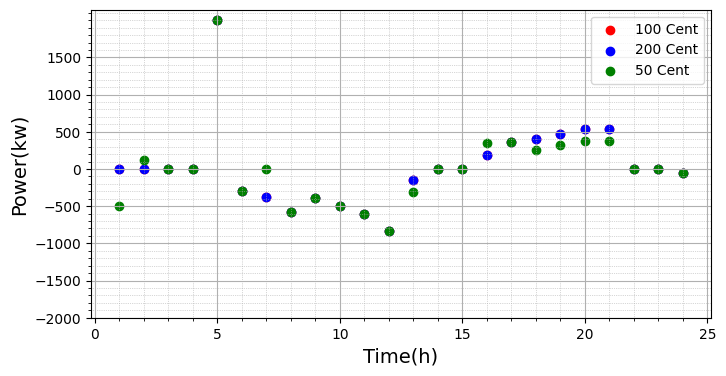

In [ ]:
y1 = []
y2 = []
y3 = []
y4 = []
y5 = []

for i in range(0,24):
  y1.append(first100.loc[i].at['Pe_Purchased'])
  y2.append(first200.loc[i].at['Pe_Purchased'])
  y3.append(first50.loc[i].at['Pe_Purchased'])

y = range(-2000 , 2000 , 500)
x = np.arange(1,25)

plt.figure(figsize=(8 , 4))
plt.minorticks_on()

plt.scatter(x , y1 , color='red'  , label="100 Cent")
plt.scatter(x , y2 , color='blue' , label="200 Cent")
plt.scatter(x , y3 , color='green' , label="50 Cent")

plt.grid()
plt.grid(which='minor', axis = "both" , linestyle='dotted', linewidth='0.5')

font1 = {"size":14}

plt.xlabel("Time(h)" , fontdict=font1)
plt.ylabel("Power(kw)" , fontdict=font1)

# plt.xticks(x)
plt.yticks(y)

plt.legend()

plt.savefig("Fig2.pdf", format="pdf", bbox_inches="tight")

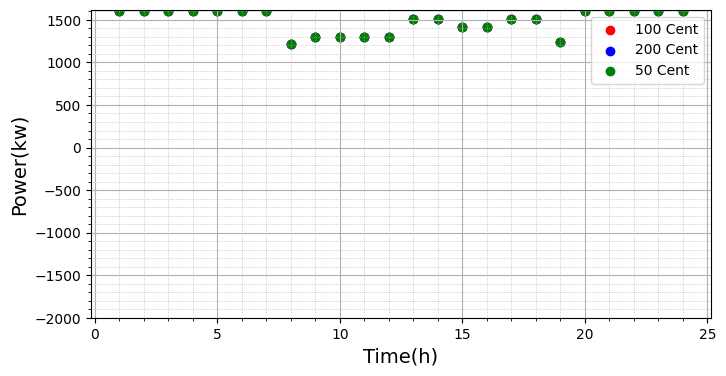

In [ ]:
y1 = []
y2 = []
y3 = []
y4 = []
y5 = []

for i in range(0,24):
  y1.append(first100.loc[i].at['Pg_Purchased'])
  y2.append(first200.loc[i].at['Pg_Purchased'])
  y3.append(first50.loc[i].at['Pg_Purchased'])

y = range(-2000 , 2000 , 500)
x = np.arange(1,25)

plt.figure(figsize=(8 , 4))
plt.minorticks_on()

plt.scatter(x , y1 , color='red'  , label="100 Cent")
plt.scatter(x , y2 , color='blue' , label="200 Cent")
plt.scatter(x , y3 , color='green' , label="50 Cent")

plt.grid()
plt.grid(which='minor', axis = "both" , linestyle='dotted', linewidth='0.5')

font1 = {"size":14}

plt.xlabel("Time(h)" , fontdict=font1)
plt.ylabel("Power(kw)" , fontdict=font1)

# plt.xticks(x)
plt.yticks(y)

plt.legend()

plt.savefig("Fig2.pdf", format="pdf", bbox_inches="tight")

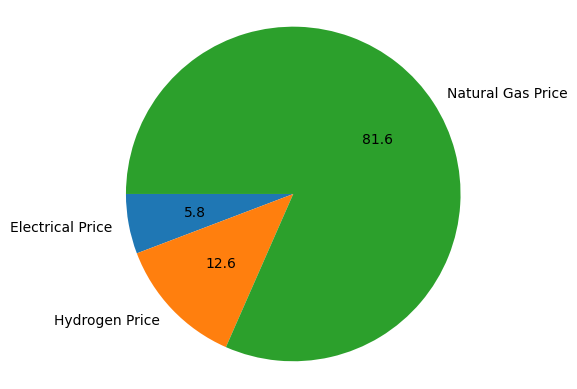

In [ ]:
E_Price = 0
H2_Price = 0
G_Price = 0
for i in range(23):
  E_Price += first100.loc[i].at['Pe_Purchased']*Lambda.loc[i].at['Lam_e']
  H2_Price += first100.loc[i].at['PH2_Purchased']*Lambda.loc[i].at['Lam_H2']
  G_Price += first100.loc[i].at['Pg_Purchased']*Lambda.loc[i].at['Lam_g']

L = [E_Price , H2_Price , G_Price]
Label = 'Electrical Price' , 'Hydrogen Price' , 'Natural Gas Price'

figureObject, axesObject = plt.subplots()

axesObject.pie(L , labels=Label , autopct='%1.1f' , startangle=180)

axesObject.axis('equal')

plt.show()


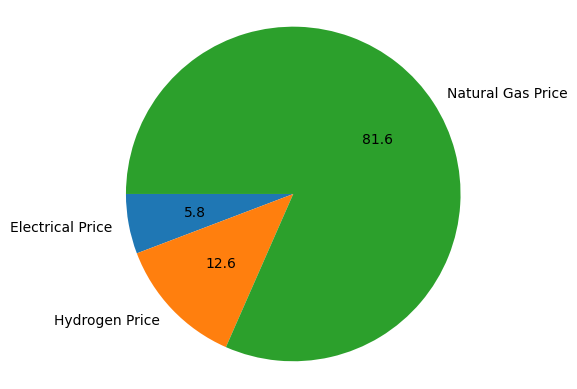

In [ ]:
E_Price = 0
H2_Price = 0
G_Price = 0
for i in range(23):
  E_Price += first200.loc[i].at['Pe_Purchased']*Lambda.loc[i].at['Lam_e']
  H2_Price += first200.loc[i].at['PH2_Purchased']*Lambda.loc[i].at['Lam_H2']
  G_Price += first200.loc[i].at['Pg_Purchased']*Lambda.loc[i].at['Lam_g']

L = [E_Price , H2_Price , G_Price]
Label = 'Electrical Price' , 'Hydrogen Price' , 'Natural Gas Price'

figureObject, axesObject = plt.subplots()

axesObject.pie(L , labels=Label , autopct='%1.1f' , startangle=180)

axesObject.axis('equal')

plt.show()

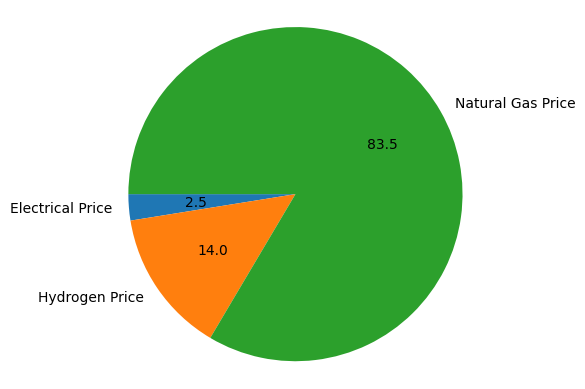

In [ ]:
E_Price = 0
H2_Price = 0
G_Price = 0
for i in range(23):
  E_Price += first50.loc[i].at['Pe_Purchased']*Lambda.loc[i].at['Lam_e']
  H2_Price += first50.loc[i].at['PH2_Purchased']*Lambda.loc[i].at['Lam_H2']
  G_Price += first50.loc[i].at['Pg_Purchased']*Lambda.loc[i].at['Lam_g']

L = [E_Price , H2_Price , G_Price]
Label = 'Electrical Price' , 'Hydrogen Price' , 'Natural Gas Price'

figureObject, axesObject = plt.subplots()

axesObject.pie(L , labels=Label , autopct='%1.1f' , startangle=180)

axesObject.axis('equal')

plt.show()

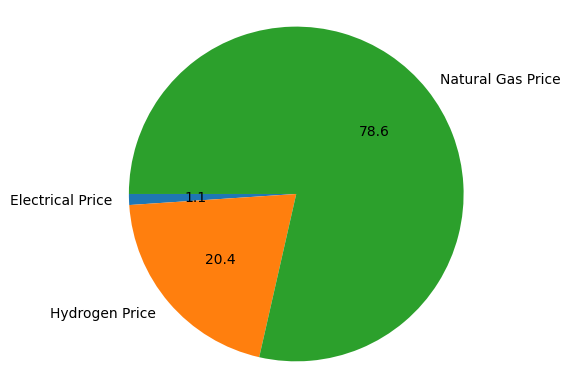

In [ ]:
E_Price = 0
H2_Price = 0
G_Price = 0
for i in range(23):
  E_Price += second100.loc[i].at['Pe_Purchased']*Lambda.loc[i].at['Lam_e']
  H2_Price += second100.loc[i].at['PH2_Purchased']*Lambda.loc[i].at['Lam_H2']
  G_Price += second100.loc[i].at['Pg_Purchased']*Lambda.loc[i].at['Lam_g']

L = [E_Price , H2_Price , G_Price]
Label = 'Electrical Price' , 'Hydrogen Price' , 'Natural Gas Price'

figureObject, axesObject = plt.subplots()

axesObject.pie(L , labels=Label , autopct='%1.1f' , startangle=180)

axesObject.axis('equal')

plt.show()


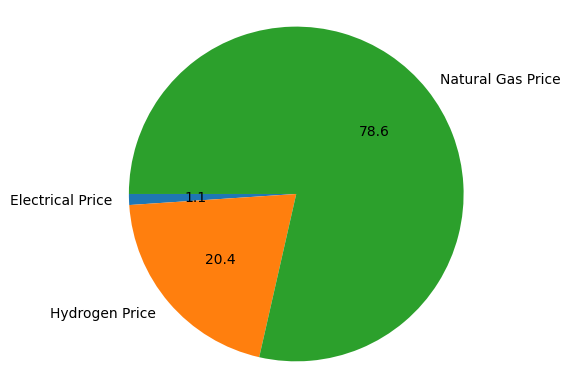

In [ ]:
E_Price = 0
H2_Price = 0
G_Price = 0
for i in range(23):
  E_Price += second200.loc[i].at['Pe_Purchased']*Lambda.loc[i].at['Lam_e']
  H2_Price += second200.loc[i].at['PH2_Purchased']*Lambda.loc[i].at['Lam_H2']
  G_Price += second200.loc[i].at['Pg_Purchased']*Lambda.loc[i].at['Lam_g']

L = [E_Price , H2_Price , G_Price]
Label = 'Electrical Price' , 'Hydrogen Price' , 'Natural Gas Price'

figureObject, axesObject = plt.subplots()

axesObject.pie(L , labels=Label , autopct='%1.1f' , startangle=180)

axesObject.axis('equal')

plt.show()


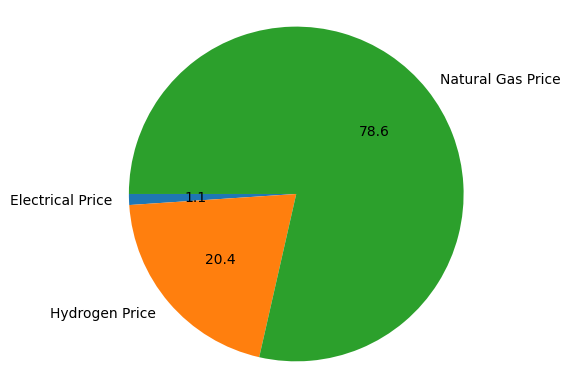

In [ ]:
E_Price = 0
H2_Price = 0
G_Price = 0
for i in range(23):
  E_Price += second50.loc[i].at['Pe_Purchased']*Lambda.loc[i].at['Lam_e']
  H2_Price += second50.loc[i].at['PH2_Purchased']*Lambda.loc[i].at['Lam_H2']
  G_Price += second50.loc[i].at['Pg_Purchased']*Lambda.loc[i].at['Lam_g']

L = [E_Price , H2_Price , G_Price]
Label = 'Electrical Price' , 'Hydrogen Price' , 'Natural Gas Price'

figureObject, axesObject = plt.subplots()

axesObject.pie(L , labels=Label , autopct='%1.1f' , startangle=180)

axesObject.axis('equal')

plt.show()
